# 데이터 불러오기 및 라벨링

### step1: 질병이 있음/없음만 구분

In [1]:
import os

# 데이터셋의 루트 디렉토리
dataset_directory = '/home/jeonk636/ear_classification/eardrumDs'

# 클래스 이름 및 라벨을 매핑하기 위한 딕셔너리 생성
# normal:0, abnormal: 1
label_map = {
    'Aom': 1,
    'Chornic': 1,
    'Earwax': 1,
    'Normal': 0,
    'OtitExterna': 1,
    'tympanoskleros': 1
}

# 이미지 파일 경로 및 라벨을 저장할 리스트
image_paths = []
image_labels = []

# 제외 폴더
exclude_folders = {'Earventulation', 'Foreign', 'PseduoMembran'}

# 각 폴더에 대해 이미지 파일 경로 및 해당 라벨을 리스트에 추가
for label_folder in os.listdir(dataset_directory):
    if label_folder in exclude_folders:  # 이 폴더는 건너뛴다.
        continue
    folder_path = os.path.join(dataset_directory, label_folder)
    
    for image_filename in os.listdir(folder_path):
        # 폴더 내 파일이 실제 파일인지 확인하고 '.ipynb_checkpoints' 폴더를 건너뛴다.
        full_path = os.path.join(folder_path, image_filename)
        if os.path.isfile(full_path) and '.ipynb_checkpoints' not in full_path:
            image_paths.append(full_path)
            image_labels.append(label_map[label_folder])


In [2]:
image_paths[0:5]

['/home/jeonk636/ear_classification/eardrumDs/Aom/aom_1.tiff',
 '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_10.tiff',
 '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_100.tiff',
 '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_101.tiff',
 '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_102.tiff']

In [3]:
print(image_labels[0:50])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [4]:
# 라벨 0과 라벨 1의 개수를 계산.
label_0_count = image_labels.count(0)
label_1_count = image_labels.count(1)

(label_0_count, label_1_count)

(534, 391)

Aom_cnt = 119  
Chornic_cnt = 62  
Earwax_cnt = 140  
Normal_cnt = 534  
OtitExterna_cnt = 41  
tympanoskleros_cnt = 28  

# Split the Dataset

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

# 이미지 경로와 라벨을 Numpy 배열로 변환
image_paths = np.array(image_paths)
image_labels = np.array(image_labels)

# 전체 데이터를 훈련+검증 세트와 테스트 세트로 분할
x_train_all, x_test, y_train_all, y_test = train_test_split(
    image_paths, image_labels, stratify=image_labels, test_size=0.2, random_state=42)

# 훈련+검증 세트를 훈련 세트와 검증 세트로 분할
x_train, x_val, y_train, y_val = train_test_split(
    x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [6]:
# 결과 출력
print("Train set:", len(x_train))
print("Validation set:", len(x_val))
print("Test set:", len(x_test))

Train set: 592
Validation set: 148
Test set: 185


In [7]:
print("Normal in Train set:", np.count_nonzero(y_train == 0))
print("Abnormal in Train set:", np.count_nonzero(y_train == 1))

Normal in Train set: 342
Abnormal in Train set: 250


In [8]:
print("image_paths shape:",image_paths.shape)
print("image_labels shape:",image_labels.shape)

image_paths shape: (925,)
image_labels shape: (925,)


# train dataset을 Augmentation

### 목표: 정상 이미지 1000장, 비정상 이미지 1000장

#### A. 여러 종류의 증강함수를 만들기   
##### (GAN, Diffusion, Few-shot learning은 나중에 적용)

### 1. Spatial-Level Transforms

In [9]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import random

2024-04-25 18:39:51.164706: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-25 18:39:51.203857: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-25 18:39:51.203879: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-25 18:39:51.205022: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-04-25 18:39:51.211803: I tensorflow/core/platform/cpu_feature_guar

In [10]:
def flip_H(image):
    flipped_H = tf.image.flip_left_right(image)
    return flipped_H

def flip_V(image):
    flipped_V = tf.image.flip_up_down(image)
    return flipped_V

def rotate(image):
    #90, 180, 270도 랜덤 회전
    #나중에 각도를 더 다양하게 적용할지 말지 고민해보기 
    k = random.randint(1, 3)
    rotated = tf.image.rot90(image, k)
    return rotated

def crop(image):
    cropped = tf.image.central_crop(image, central_fraction=0.5)
    return cropped

In [11]:
# 이미지 파일을 로드하고 텐서로 변환하는 함수
def load_and_preprocess_image(path):
    image = Image.open(path)
    image = image.convert('RGB')  # PIL 이미지를 RGB로 변환 (필요한 경우)
    image = np.array(image)       # NumPy 배열로 변환
    image = tf.image.convert_image_dtype(image, tf.float32)  # TensorFlow 텐서로 변환
    return image

# 이미지 경로로부터 이미지를 로드
ex_path = x_train_all[20]  # 예시 이미지 경로
image = load_and_preprocess_image(ex_path)

Spatial_aug = {
    'flip_H': flip_H(image),
    'flip_V': flip_V(image),
    'rotate': rotate(image),
    'crop': crop(image)
}

# 이미지를 시각화하기 위한 함수
def visualize_Spatial(image, Spatial_aug):
    fig, axes = plt.subplots(1, len(Spatial_aug) + 1, figsize=(20, 10))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    for i, (augmentation_name, augmented_image) in enumerate(Spatial_aug.items(), 1):
        axes[i].imshow(augmented_image)
        axes[i].set_title(augmentation_name)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

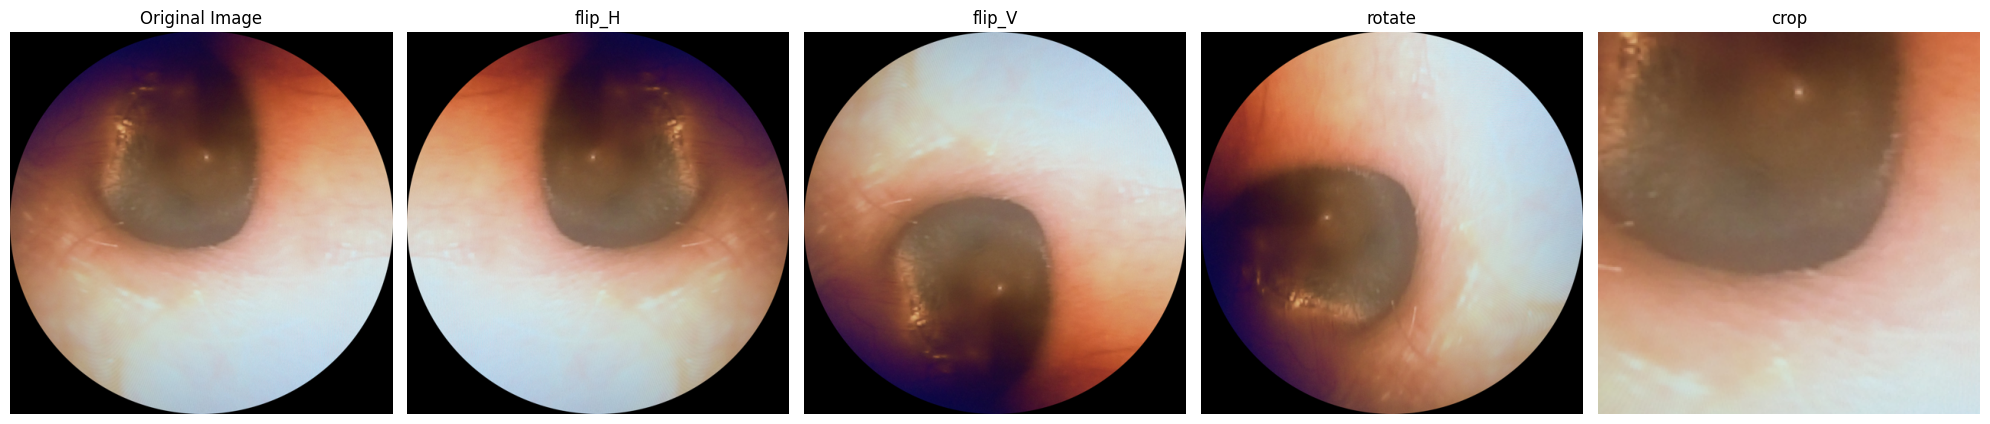

In [12]:
visualize_Spatial(image, Spatial_aug)

### 2.Pixel-Level Transforms

In [13]:
def CLAHE(image):
    # TensorFlow 텐서를 NumPy 배열로 변환하고 0-255 범위의 값으로 조정
    image = (image.numpy() * 255).astype(np.uint8)
    # RGB 채널을 BGR로 변경
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    # 각 채널에 CLAHE 적용
    channels = cv2.split(image)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahed_channels = [clahe.apply(c) for c in channels]
    clahed_image = cv2.merge(clahed_channels)
    # 다시 RGB 채널로 변경
    clahed_image = cv2.cvtColor(clahed_image, cv2.COLOR_BGR2RGB)
    # 이미지를 [0, 1] 범위로 정규화
    clahed_image = clahed_image / 255.0
    return clahed_image
    
def Hue(image):
    # HueSaturationValue
    hue_img = tf.image.adjust_hue(image, delta=0.1)
    hue_img = tf.image.adjust_saturation(hue_img, saturation_factor=1)
    return hue_img

def RandomContrast(image):
    # 이미지에 RandomContrast를 적용하고 결과를 [0, 1] 범위로 클리핑
    contrast_image = tf.image.random_contrast(image, lower=1.0, upper=3.0)
    contrast_image = tf.clip_by_value(contrast_image, 0.0, 1.0)  # 클리핑
    return contrast_image

def RandomGamma(image):
    # RandomGamma
    gamma_img = tf.image.adjust_gamma(image, gamma=0.5)
    return gamma_img

def RandomBrightness(image):
    # 이미지에 RandomBrightness를 적용하고 결과를 [0, 1] 범위로 클리핑
    bright_image = tf.image.random_brightness(image, max_delta=0.3)
    bright_image = tf.clip_by_value(bright_image, 0.0, 1.0)  # 클리핑
    return bright_image

def Blur(image):
    # TensorFlow 텐서를 NumPy 배열로 변환
    image = image.numpy()
    blur_img = cv2.blur(image, (5, 5))
    return blur_img

def gray(image):
    # ToGray
    togray_img = tf.image.rgb_to_grayscale(image)
    return togray_img

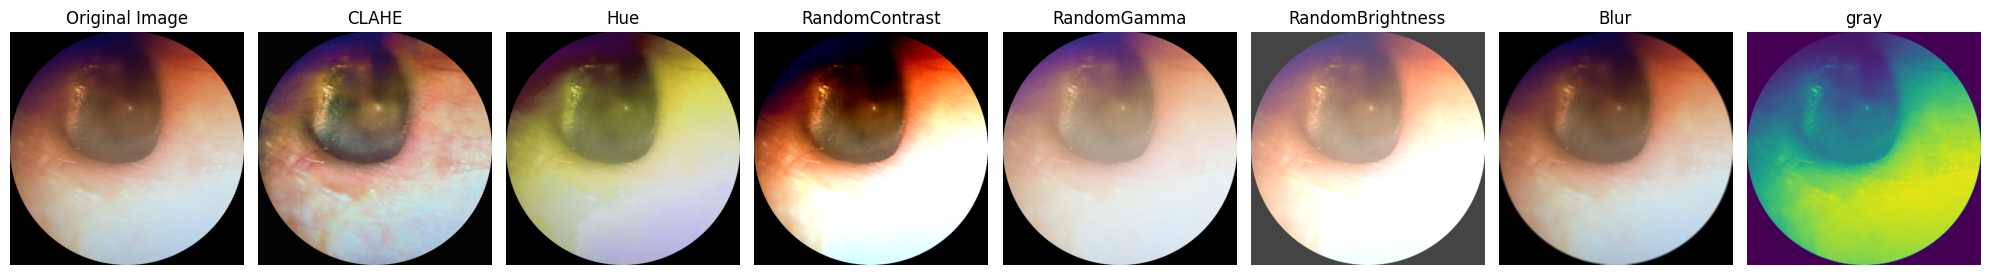

In [14]:
# 시각화를 위한 함수
def visualize_augmentations(image, augmentations):
    fig, axes = plt.subplots(1, len(augmentations) + 1, figsize=(20, 10))
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    for i, (augmentation_name, augmented_image) in enumerate(augmentations.items(), 1):
        axes[i].imshow(augmented_image)
        axes[i].set_title(augmentation_name)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# 각 증강 기법을 적용.
augmentations = {
    'CLAHE': CLAHE(image),
    'Hue': Hue(image),
    'RandomContrast': RandomContrast(image),
    'RandomGamma': RandomGamma(image),
    'RandomBrightness': RandomBrightness(image),
    'Blur': Blur(image),
    'gray': gray(image)
}

# 시각화 실행
visualize_augmentations(image, augmentations)

### train data set에 증강함수 적용

In [15]:
augmentation_ratios = {
    'flip_H': 0.25,
    'flip_V': 0.25,
    'rotate': 0.25,
    'crop': 0.25,
    'CLAHE': 0.1,
    'Hue': 0.1,
    'RandomContrast': 0.1,
    'RandomGamma': 0.1,
    'RandomBrightness': 0.3,
    'Blur': 0.2,
    'gray': 0.1
}

augmentation_functions = {
    'flip_H': flip_H,
    'flip_V': flip_V,
    'rotate': rotate,
    'crop': crop,
    'CLAHE': CLAHE,
    'Hue': Hue,
    'RandomContrast': RandomContrast,
    'RandomGamma': RandomGamma,
    'RandomBrightness': RandomBrightness,
    'Blur': Blur,
    'gray': gray
}

### ---- 어떻게 증강함수를 적용할 수 있는지 모르겠음 -----

### -------------

### (계획변경) 증강하지 않은 이미지에 대한 CNN모델 적용

In [16]:
from PIL import Image

# 이미지 파일 열기
img = Image.open('/home/jeonk636/ear_classification/eardrumDs/Aom/aom_1.tiff')

# 이미지의 너비, 높이 얻기
image_width, image_height = img.size

# 이미지의 채널 수 얻기
num_channels = len(img.getbands())

print('Image Width: ', image_width)
print('Image Height: ', image_height)
print('Number of Channels: ', num_channels)

Image Width:  500
Image Height:  500
Number of Channels:  3


#### 참고문헌: https://www.tensorflow.org/tutorials/images/cnn?hl=ko  

In [17]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def load_and_preprocess_image(image_path, target_size=(500, 500)):
    img = load_img(image_path, target_size=target_size)
    img = img_to_array(img)
    img = img / 255.0  # Normalize to [0,1]
    return img

# Assuming x_train, x_val, x_test are lists of image file paths
x_train = np.array([load_and_preprocess_image(path) for path in x_train])
x_val = np.array([load_and_preprocess_image(path) for path in x_val])
x_test = np.array([load_and_preprocess_image(path) for path in x_test])

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=50, validation_data=(x_val, y_val))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/50
19/19 [==============================] - 12s 550ms/step - loss: 8.7666 - accuracy: 0.5253 - val_loss: 0.6745 - val_accuracy: 0.5811
Epoch 2/50
19/19 [==============================] - 9s 495ms/step - loss: 0.6634 - accuracy: 0.5777 - val_loss: 0.6661 - val_accuracy: 0.5743
Epoch 3/50
19/19 [==============================] - 9s 478ms/step - loss: 0.6572 - accuracy: 0.5777 - val_loss: 0.6833 - val_accuracy: 0.5743
Epoch 4/50
19/19 [==============================] - 10s 467ms/step - loss: 0.6559 - accuracy: 0.5777 - val_loss: 0.6641 - val_accuracy: 0.5743
Epoch 5/50
19/19 [==============================] - 9s 469ms/step - loss: 0.6444 - accuracy: 0.5946 - val_loss: 0.6653 - val_accuracy: 0.6149
Epoch 6/50
19/19 [==============================] - 9s 465ms/step - loss: 0.6450 - accuracy: 0.6301 - val_loss: 0.6634 - val_accuracy: 0.6014
Epoch 7/50
19/19 [==============================] - 9s 464ms/step - loss: 0.6444 - accuracy: 0.6216 - val_loss: 0.6719 - val_accuracy: 0.6351
Epoc

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 249, 249, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 123, 123, 64)      0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 968256)            0         
                                                                 
 dense (Dense)               (None, 64)                6

5/5 - 1s - loss: 1.6054 - accuracy: 0.6149 - 606ms/epoch - 121ms/step


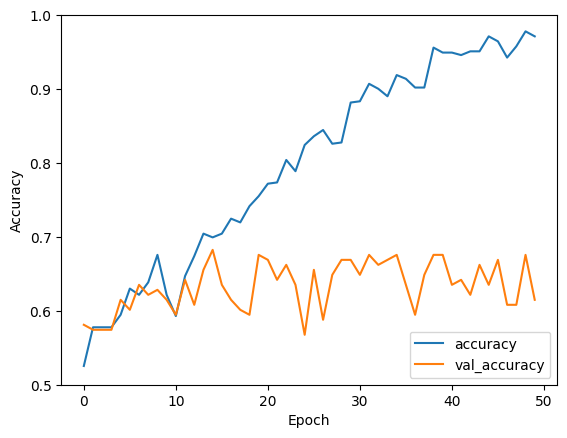

In [19]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_val,  y_val, verbose=2)

##### 과적합 발생  
##### 증강을 했을 경우와 비교 